In [1]:
from transformers import pipeline
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from PIL import Image
import numpy as np
import torch
from diffusers.utils import load_image

from PIL import Image
import numpy as np
import cv2

/home/luisa/anaconda3/envs/test2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
LORA_MODEL_PATH ="weights/dense_fog_lora"
DEPTHMAP_FILEPATH =  "samples/00000440_depth_front.png"

NEGATIVE_PROMPT="monochrome, lowres, unrealistic, worst quality, low quality, cartoon, painting, drawing, digital art, black and white"
PROMPT = "streetscape, dense fog, high quality photography, Canon EOS R3, street, natural lighting, detailed shadows, 35 mm lens"

In [3]:
def load_depth_map (depthmap_filepath, size = 512):
    
    size = size
    filepath = depthmap_filepath
    
    depth_map = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
    B, G, R = cv2.split(depth_map)
    depth_map = 255.0 / ( (256 * 256 * B + 256 * G + R) / (256 * 256 * 256 - 1) * 500 )
    depth = cv2.resize(depth_map, (size,size), interpolation=cv2.INTER_AREA).astype(np.uint8)
    depth = Image.fromarray(depth)
    
    return depth

/home/luisa/anaconda3/envs/test2/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|█████████████| 6/6 [00:00<00:00,  6.92it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.

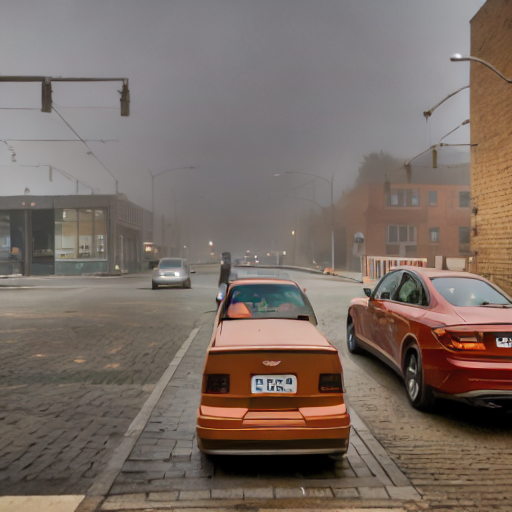

In [4]:
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-depth", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16
)

pipe.load_lora_weights(LORA_MODEL_PATH)
pipe.to("cuda")


depth = load_depth_map(DEPTHMAP_FILEPATH)

output_image = pipe(PROMPT, depth, negative_prompt=NEGATIVE_PROMPT, num_inference_steps=50).images[0]

output_image